<a href="https://colab.research.google.com/github/LongNguyen1984/DeepLearning/blob/master/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This tutor shows how to build a autoencoder for denoise

In [39]:
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import optimizers
from tensorflow.keras.optimizers import Adam

(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_x = x_train.reshape(60000, 784)/255
val_x = x_test.reshape(10000, 784)/255

autoencoder = Sequential()
autoencoder.add(Dense(512, activation='elu', input_shape=(784,)))
autoencoder.add(Dense(128, activation='elu'))
autoencoder.add(Dense(10, activation='linear', name='bottleneck'))
autoencoder.add(Dense(128, activation='elu'))
autoencoder.add(Dense(512, activation='elu'))
autoencoder.add(Dense(784, activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer=Adam())
trained_model = autoencoder.fit(train_x, train_x, batch_size=1024, epochs=10, verbose=1, validation_data=(val_x, val_x))
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
endcoded_data = encoder.predict(train_x) # bottleneck representation
decoded_output = autoencoder.predict(train_x) # reconstruction
encoding_dim = 10

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

Epoch 1/10
59/59 [==============================] - 10s 169ms/step - loss: 0.0753 - val_loss: 0.0493
Epoch 2/10
59/59 [==============================] - 7s 112ms/step - loss: 0.0417 - val_loss: 0.0355
Epoch 3/10
59/59 [==============================] - 7s 112ms/step - loss: 0.0327 - val_loss: 0.0291
Epoch 4/10
59/59 [==============================] - 7s 115ms/step - loss: 0.0279 - val_loss: 0.0260
Epoch 5/10
59/59 [==============================] - 7s 115ms/step - loss: 0.0254 - val_loss: 0.0240
Epoch 6/10
59/59 [==============================] - 7s 115ms/step - loss: 0.0237 - val_loss: 0.0227
Epoch 7/10
59/59 [==============================] - 7s 114ms/step - loss: 0.0226 - val_loss: 0.0216
Epoch 8/10
59/59 [==============================] - 7s 114ms/step - loss: 0.0215 - val_loss: 0.0207
Epoch 9/10
59/59 [==============================] - 7s 115ms/step - loss: 0.0207 - val_loss: 0.0200
Epoch 10/10
59/59 [==============================] - 7s 115ms/step - loss: 0.0200 - val_loss: 0.019

In [7]:
y_train[5]

2

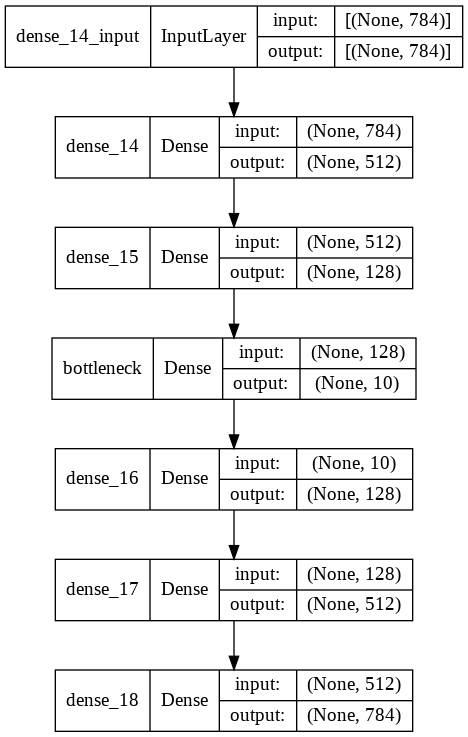

In [30]:
from keras.utils.vis_utils import plot_model


plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True, show_layer_names=True)

In [9]:
autoencoder.layers

In [10]:
autoencoder.layers[-3]._name='postBottleNeck'

In [51]:
%matplotlib inline
from keras.preprocessing import image
from keras.datasets import fashion_mnist
(x1_train, y1_train), (x1_test, y1_test) = fashion_mnist.load_data()
# if the img.png is not one of the MNIST dataset that the model was trained on, the error will be very high.
#img = image.load_img("./img.png", target_size=(28, 28), color_mode = "grayscale")
img = x_train[1000]
input_img = image.img_to_array(img)
inputs = input_img.reshape(1,np.shape(input_img)[2]*784)
target_data = autoencoder.predict(inputs)
dist = np.linalg.norm(inputs - target_data, axis=-1)
print(dist)
img2 = target_data.reshape(28,28)

[2276.0178]


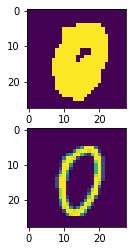

In [52]:
import matplotlib.pyplot as plt
plt.subplot(2,1,1)
plt.imshow(img2)
plt.subplot(2,1,2)
plt.imshow(img)

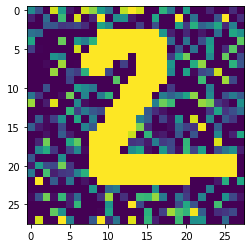

In [53]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

#Print one image to see the noise
plt.imshow(x_test_noisy[1].reshape(28, 28))

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
input_img = Input(shape=(28, 28, 1))

nn = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
nn = MaxPooling2D((2, 2), padding='same')(nn)
nn = Conv2D(32, (3, 3), activation='relu', padding='same')(nn)
encoded = MaxPooling2D((2, 2), padding='same')(nn)


nn = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
nn = UpSampling2D((2, 2))(nn)
nn = Conv2D(32, (3, 3), activation='relu', padding='same')(nn)
nn = UpSampling2D((2, 2))(nn)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(nn)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta',loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=256,
                validation_data=(x_test_noisy, x_test))

In [67]:
%matplotlib inline
from keras.preprocessing import image
from keras.datasets import fashion_mnist
(x1_train, y1_train), (x1_test, y1_test) = fashion_mnist.load_data()
# if the img.png is not one of the MNIST dataset that the model was trained on, the error will be very high.
#img = image.load_img("./img.png", target_size=(28, 28), color_mode = "grayscale")
img = x_train_noisy[1:10]
#input_img = image.img_to_array(img)
#inputs = input_img.reshape(1,np.shape(input_img)[2]*784)
target_data = autoencoder.predict(img)
#dist = np.linalg.norm(img - target_data, axis=-1)
#print(dist)
img2 = target_data.reshape(9, 28,28)

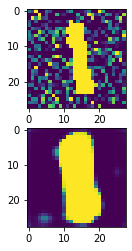

In [72]:
import matplotlib.pyplot as plt
plt.subplot(2,1,1)
plt.imshow(img[5])
plt.subplot(2,1,2)
plt.imshow(img2[5])